Name: Hassan Mansoor

CMS: 403544

Class: BSCS12A

Deep Learning Assign 03

# **Montreal Fall Dataset**

Imports

In [ ]:
import os
import cv2
import numpy as np
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
dataset_root = '/content/Montreal Dataset'

for root, dirs, files in os.walk(dataset_root):
    print(f'Directory: {root}')
    for file in files[:5]:
        print(f'  File: {file}')
    print()


Directory: /content/Montreal Dataset

Directory: /content/Montreal Dataset/dataset

Directory: /content/Montreal Dataset/dataset/chute07
  File: cam3.avi
  File: cam7.avi
  File: cam4.avi
  File: cam2.avi
  File: cam8.avi

Directory: /content/Montreal Dataset/dataset/chute23
  File: cam3.avi
  File: cam7.avi
  File: cam4.avi
  File: cam2.avi
  File: cam8.avi

Directory: /content/Montreal Dataset/dataset/chute15
  File: cam3.avi
  File: cam7.avi
  File: cam4.avi
  File: cam2.avi
  File: cam8.avi

Directory: /content/Montreal Dataset/dataset/chute16
  File: cam3.avi
  File: cam7.avi
  File: cam4.avi
  File: cam2.avi
  File: cam8.avi

Directory: /content/Montreal Dataset/dataset/chute08
  File: cam3.avi
  File: cam7.avi
  File: cam4.avi
  File: cam2.avi
  File: cam8.avi

Directory: /content/Montreal Dataset/dataset/chute14
  File: cam3.avi
  File: cam7.avi
  File: cam4.avi
  File: cam2.avi
  File: cam8.avi

Directory: /content/Montreal Dataset/dataset/chute20
  File: cam3.avi
  File: cam7

#Load and View a Sample Video

We'll load a sample video (say chute01/cam3.avi) and display a few frames.

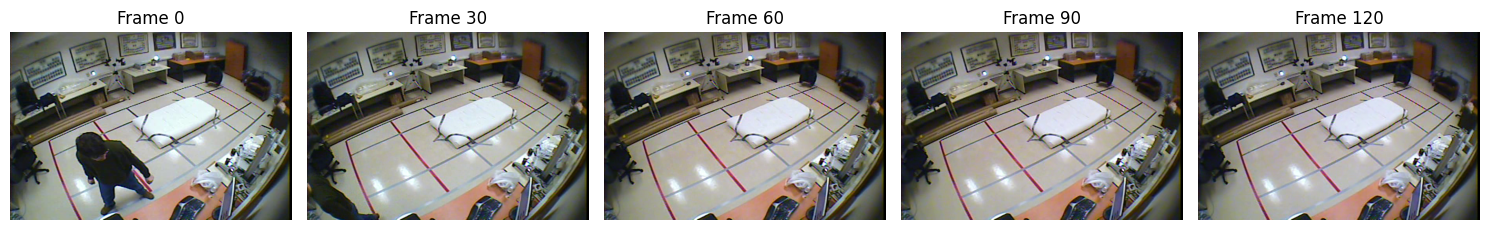

In [ ]:
import cv2
import matplotlib.pyplot as plt

# sample video
sample_video_path = '/content/Montreal Dataset/dataset/chute01/cam3.avi'

# load video
cap = cv2.VideoCapture(sample_video_path)

# Grab and show 5 sample frames
num_frames_to_show = 5
frame_ids = [0, 30, 60, 90, 120]  # Every 30th frame, assuming 30 FPS

plt.figure(figsize=(15, 5))

for i, fid in enumerate(frame_ids):
    cap.set(cv2.CAP_PROP_POS_FRAMES, fid)
    ret, frame = cap.read()
    if ret:
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num_frames_to_show, i + 1)
        plt.imshow(frame_rgb)
        plt.title(f"Frame {fid}")
        plt.axis('off')

cap.release()
plt.tight_layout()
plt.show()


# **Load Ground Truth Labels**

We need to load and parse the ground-truth.txt file to match the video frames with corresponding labels.

In [ ]:
# Function to load ground-truth labels from the text file
def load_ground_truth(ground_truth_path):
    labels = []
    with open(ground_truth_path, 'r') as file:
        for line in file:
            scenario, camera, start_frame, end_frame, position = line.strip().split(',')
            labels.append({
                'scenario': int(scenario),
                'camera': int(camera),
                'start_frame': int(start_frame),
                'end_frame': int(end_frame),
                'position': int(position)
            })
    return labels

# Load the ground truth data
ground_truth_path = '/content/ground-truth.txt'  # Path to your ground-truth file
ground_truth_labels = load_ground_truth(ground_truth_path)


Extract Keypoints

In [ ]:
def extract_pose_keypoints(video_path):
    cap = cv2.VideoCapture(video_path)
    keypoints_list = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        results = pose.process(image_rgb)

        if results.pose_landmarks:
            keypoints = []
            for landmark in results.pose_landmarks.landmark:
                keypoints.append([landmark.x, landmark.y, landmark.z, landmark.visibility])
            keypoints_list.append(keypoints)

    cap.release()
    return np.array(keypoints_list)

For each video, we will:

Extract the keypoints.

Compare the video frame indices with the start_frame and end_frame from the ground truth.

Assign the position label to each frame.

In [ ]:
def label_keypoints_with_fall(keypoints_data, ground_truth_labels, video_path):
    # Get video frame count
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  # Total number of frames in the video
    cap.release()

    # Create a list to store labeled keypoints
    labeled_keypoints = []

    # Loop through each frame in the keypoints data
    for frame_idx in range(frame_count):
        # Default label as "no fall"
        label = 'no fall'

        # Find the ground truth label for this frame
        for gt in ground_truth_labels:
            if gt['start_frame'] <= frame_idx <= gt['end_frame']:
                if gt['position'] == 2:  # If the position is "2" (falling), label as "fall"
                    label = 'fall'
                break

        # Append the keypoints and label (if found) to the list
        if frame_idx < len(keypoints_data):
            labeled_keypoints.append({'frame_idx': frame_idx, 'keypoints': keypoints_data[frame_idx], 'label': label})

    return labeled_keypoints


Label Matching: For each frame in the video, the system checks whether the frame index falls within the range specified in the ground-truth.txt file for each "fall" scenario. If a frame falls within a "fall" range, the corresponding frame will be labeled as a "fall." Otherwise, the frame will be labeled as "no fall."

Now we will iterate through all the folders (chute01 to chute24) and videos (cam1.avi, cam2.avi, etc.) to extract keypoints and label them using the ground truth.

In [ ]:
dataset_root = '/content/Montreal Dataset/dataset' # root of data

In [ ]:
def process_entire_dataset_with_fall(dataset_root, ground_truth_labels):
    all_labeled_data = []

    # Loop through each 'chute' folder (chute01, chute02, ..., chute24)
    for chute_folder in os.listdir(dataset_root):
        chute_path = os.path.join(dataset_root, chute_folder)
        if os.path.isdir(chute_path):
            print(f"Processing {chute_folder}...")

            # Loop through each video (cam1.avi, cam2.avi, ..., cam8.avi)
            for video_file in os.listdir(chute_path):
                if video_file.endswith('.avi'):
                    video_path = os.path.join(chute_path, video_file)

                    # Extract keypoints from the video
                    print(f"  Extracting keypoints from {video_file}...")
                    keypoints_data = extract_pose_keypoints(video_path)

                    # Label the keypoints with "fall" and "no fall"
                    labeled_data = label_keypoints_with_fall(keypoints_data, ground_truth_labels, video_path)
                    all_labeled_data.extend(labeled_data)
    return all_labeled_data

process the data

In [ ]:
# Process the dataset
labeled_dataset = process_entire_dataset_with_fall(dataset_root, ground_truth_labels)

Processing chute07...
  Extracting keypoints from cam3.avi...
  Extracting keypoints from cam7.avi...
  Extracting keypoints from cam4.avi...
  Extracting keypoints from cam2.avi...
  Extracting keypoints from cam8.avi...
  Extracting keypoints from cam5.avi...
  Extracting keypoints from cam1.avi...
  Extracting keypoints from cam6.avi...
Processing chute23...
  Extracting keypoints from cam3.avi...
  Extracting keypoints from cam7.avi...
  Extracting keypoints from cam4.avi...
  Extracting keypoints from cam2.avi...
  Extracting keypoints from cam8.avi...
  Extracting keypoints from cam5.avi...
  Extracting keypoints from cam1.avi...
  Extracting keypoints from cam6.avi...
Processing chute15...
  Extracting keypoints from cam3.avi...
  Extracting keypoints from cam7.avi...
  Extracting keypoints from cam4.avi...
  Extracting keypoints from cam2.avi...
  Extracting keypoints from cam8.avi...
  Extracting keypoints from cam5.avi...
  Extracting keypoints from cam1.avi...
  Extracting k

In [ ]:
import json

output_path = '/content/labeled_keypoints.json'
with open(output_path, 'w') as f:
    json.dump(labeled_dataset, f)

print(f"Labeled keypoints saved to {output_path}")


send this to drive

In [ ]:
import shutil

# Define the source file path in Colab
source_file_path = '/content/labeled_keypoints.json'

# Define the destination path in Google Drive
destination_file_path = '/content/drive/MyDrive/labeled_keypoints.json'

# Copy the file to Google Drive
shutil.copy(source_file_path, destination_file_path)

print(f"File copied to {destination_file_path}")

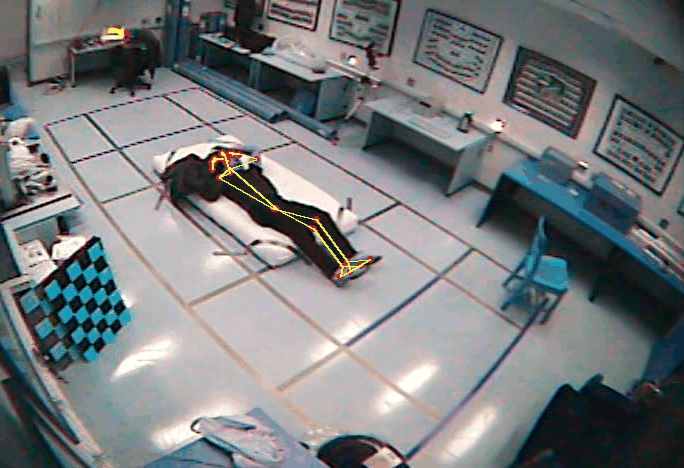

# **Feature Engineering and Feature Extraction**

Angle between 3 points

In [ ]:
def calculate_angle(joint_a, joint_b, joint_c):
    # Vectors from joint B to A and B to C
    vector_ab = np.array([joint_a[0] - joint_b[0], joint_a[1] - joint_b[1]])
    vector_bc = np.array([joint_c[0] - joint_b[0], joint_c[1] - joint_b[1]])

    # Dot product and magnitudes
    dot_product = np.dot(vector_ab, vector_bc)
    mag_ab = np.linalg.norm(vector_ab)
    mag_bc = np.linalg.norm(vector_bc)

    # Angle in radians
    angle_rad = np.arccos(dot_product / (mag_ab * mag_bc))

    # Convert to degrees
    angle_deg = np.degrees(angle_rad)
    return angle_deg


Center of gravity

In [ ]:
def calculate_cog(keypoints):
    # Extract x and y coordinates of major keypoints (e.g., hips, shoulders, etc.)
    major_keypoints = [keypoints[5], keypoints[6], keypoints[11], keypoints[12]]  # Example: shoulders and hips
    x_coords = [point[0] for point in major_keypoints]
    y_coords = [point[1] for point in major_keypoints]

    # CoG = average of x and y coordinates
    cog_x = np.mean(x_coords)
    cog_y = np.mean(y_coords)

    return cog_x, cog_y

Velocity/Acceleration

In [ ]:
def calculate_velocity(prev_position, current_position, time_diff):
    displacement = np.linalg.norm(np.array(current_position) - np.array(prev_position))
    velocity = displacement / time_diff
    return velocity

# Calculate acceleration based on velocity
def calculate_acceleration(prev_velocity, current_velocity, time_diff):
    acceleration = (current_velocity - prev_velocity) / time_diff
    return acceleration

# **Main Feature Extraction**

In [ ]:
def extract_features_from_labeled_data(labeled_data, time_diff=1/30):
    features_list = []

    # Iterate over each labeled frame in the dataset
    prev_keypoints = None
    prev_velocities = np.zeros((33,))
    for data in labeled_data:
        frame_idx = data['frame_idx']
        keypoints = data['keypoints']
        label = data['label']

        # extract the coordinates (x, y, z)
        keypoints_coords = np.array([kp[:3] for kp in keypoints])
        confidences = np.array([kp[3] for kp in keypoints])  # Confidence

        # frame features initialised.
        frame_features = {
            'frame_idx': frame_idx,
            'label': label,
            'joint_angles': [],
            'cog': [],
            'velocity': [],
            'acceleration': [],
            'confidence_scores': confidences.tolist()
        }

        # joint angles

        shoulder = keypoints[5]
        elbow = keypoints[7]
        wrist = keypoints[9]
        elbow_angle = calculate_angle(shoulder, elbow, wrist)
        frame_features['joint_angles'].append(elbow_angle)

        # knee angle
        hip = keypoints[11]
        knee = keypoints[13]
        ankle = keypoints[15]
        knee_angle = calculate_angle(hip, knee, ankle)
        frame_features['joint_angles'].append(knee_angle)

        # CoG
        cog_x, cog_y = calculate_cog(keypoints_coords)
        frame_features['cog'] = [cog_x, cog_y]

        # velocity/acc
        if prev_keypoints is not None:
            for i in range(len(keypoints_coords)):
                current_position = keypoints_coords[i][:2]
                prev_position = prev_keypoints[i][:2]

                # velocity for each keypoint
                velocity = calculate_velocity(prev_position, current_position, time_diff)
                frame_features['velocity'].append(velocity)

                if i < len(prev_velocities):
                    prev_velocity = prev_velocities[i]
                    # acc
                    acceleration = calculate_acceleration(prev_velocity, velocity, time_diff)
                    frame_features['acceleration'].append(acceleration)

            # update velo
            prev_velocities = frame_features['velocity']

        # store the features!
        features_list.append(frame_features)

        # update old keypoints.
        prev_keypoints = keypoints_coords

    return features_list

In [ ]:
labeled_data = labeled_dataset # new data

In [ ]:
features = extract_features_from_labeled_data(labeled_data) # Extract The Features

Verify features

In [ ]:
print(features[0])

{'frame_idx': 0, 'label': 'no fall', 'joint_angles': [np.float64(39.57602038788912), np.float64(155.12252709843276)], 'cog': [np.float64(0.10148502141237259), np.float64(0.6881431043148041)], 'velocity': [], 'acceleration': [], 'confidence_scores': [0.9879221320152283, 0.9868377447128296, 0.9858173131942749, 0.9884986877441406, 0.9838213324546814, 0.9784896969795227, 0.9841823577880859, 0.9811471104621887, 0.9785771369934082, 0.970377504825592, 0.9604395627975464, 0.9985626935958862, 0.9921368956565857, 0.8435302376747131, 0.497982382774353, 0.77692711353302, 0.541670024394989, 0.7257617115974426, 0.4988504648208618, 0.720314621925354, 0.5029064416885376, 0.6970488429069519, 0.501962423324585, 0.9995325803756714, 0.9990878701210022, 0.8296969532966614, 0.49989208579063416, 0.7781969308853149, 0.4869809150695801, 0.7733100652694702, 0.5484426021575928, 0.7881138920783997, 0.5774035453796387]}


We'll use a sliding window approach to generate sequences of features across consecutive frames, which helps the classifier learn temporal dynamics.

In [ ]:
import numpy as np

def create_sequences(labeled_data, window_size=30, stride=5):
    sequences = []
    labels = []

    num_frames = len(labeled_data)

    for i in range(0, num_frames - window_size + 1, stride):
        window = labeled_data[i:i+window_size]

        # Extract keypoints only (shape: window_size x 33 x 4)
        keypoints_seq = [frame['keypoints'] for frame in window]

        # Flatten each keypoint into 132-dim (33 keypoints * 4 values)
        keypoints_seq = np.array(keypoints_seq).reshape(window_size, -1)

        # Label = 1 if any frame in the window is labeled "fall"
        fall_labels = [1 if frame['label'] == 'fall' else 0 for frame in window]
        sequence_label = 1 if any(fall_labels) else 0

        sequences.append(keypoints_seq)
        labels.append(sequence_label)

    return np.array(sequences), np.array(labels)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Create sequences and labels
X, y = create_sequences(labeled_dataset)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


LSTM Classifier

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.1),
    LSTM(32),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 30, 64)         │        50,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,937 (249.75 KB)

 Trainable params: 63,937 (249.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Apply SMOTE
from imblearn.over_sampling import SMOTE

X_train_flat = X_train.reshape((X_train.shape[0], -1))
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train_flat, y_train)
X_resampled = X_resampled.reshape((X_resampled.shape[0], 30, 132))

# Train model
history = model.fit(
    X_resampled, y_resampled,
    epochs=15,
    batch_size=16,
    validation_data=(X_test, y_test),
    verbose=1
)


Epoch 1/15
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 50s 24ms/step - accuracy: 0.6996 - loss: 0.5736 - val_accuracy: 0.6623 - val_loss: 0.6012
Epoch 2/15
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 51s 24ms/step - accuracy: 0.7128 - loss: 0.5548 - val_accuracy: 0.6635 - val_loss: 0.5723
Epoch 3/15
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 51s 24ms/step - accuracy: 0.7299 - loss: 0.5349 - val_accuracy: 0.6667 - val_loss: 0.5865
Epoch 4/15
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 49s 23ms/step - accuracy: 0.7401 - loss: 0.5166 - val_accuracy: 0.6390 - val_loss: 0.5989
Epoch 5/15
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 48s 23ms/step - accuracy: 0.7549 - loss: 0.4992 - val_accuracy: 0.6553 - val_loss: 0.5714
Epoch 6/15
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 49s 23ms/step - accuracy: 0.7356 - loss: 0.5242 - val_accuracy: 0.6572 - val_loss: 0.6111
Epoch 7/15
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 50s 23ms/step - accuracy: 0.7645 - loss: 0.4833 - val_accuracy: 0.6967 - val_loss: 0.5704
Epoch 8/15
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 48s 23ms/step - accuracy: 0.7794 -

In [ ]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc* 100:.2f}%")


277/277 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7525 - loss: 0.4939
Test Accuracy: 74.86%


----------------------- end